# 📘 Silver Price Analysis & Forecasting (2016–2026)

Author: Professional Data Scientist
Dataset: Yahoo Finance (SI=F – COMEX Silver Futures)
Period: Jan 2016 – Jan 2026
Objective: Analyze historical trends, model price behavior, and forecast silver prices for Q1 2026.

# 📌 Business Context

Silver is both:

- A precious metal investment hedge

- A critical industrial input (solar panels, electronics, EVs)

Understanding its price dynamics, seasonality, and forecasted movement is essential for:

- Investors

- Policy analysts

- Commodity traders

## 🧠 Hypothesis

1. Silver prices exhibit long-term upward drift driven by inflation and industrial demand

2. There is seasonality in silver futures pricing

3. Machine learning and time-series models outperform naive forecasts

4. Prophet captures trend + seasonality better than classical ML for long horizons

# 📦 Libraries & Environment

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Prophet
from prophet import Prophet

# Settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


# 📂 Data Loading & Overview

In [3]:
df = pd.read_csv("silver_price_forecast_2026.csv")

df.head()


Date  Predicted_Price  yhat_lower  yhat_upper
0  2026-01-17        51.928813   45.206596   58.066802
1  2026-01-18        51.804914   45.477966   58.787783
2  2026-01-19        51.855349   45.330520   57.810983
3  2026-01-20        51.719222   45.371847   57.933906
4  2026-01-21        51.639744   44.860422   57.979644

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             90 non-null     object 
 1   Predicted_Price  90 non-null     float64
 2   yhat_lower       90 non-null     float64
 3   yhat_upper       90 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.9+ KB


In [5]:
df.describe()


Predicted_Price  yhat_lower  yhat_upper
count        90.000000   90.000000   90.000000
mean         51.974220   45.443955   58.477469
std           0.847955    0.846176    0.925547
min          50.577075   43.767582   56.944332
25%          51.365873   44.860929   57.787961
50%          51.896631   45.363523   58.413480
75%          52.503165   45.837030   58.997174
max          53.824936   47.668879   61.074626

### 🔎 Dataset Structure

- Date: Trading date

- Open, High, Low, Close

- Adj Close

- Volume

# 🧹 Data Preprocessing

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

df.isna().sum()


Predicted_Price    0
yhat_lower         0
yhat_upper         0
dtype: int64

In [7]:
df = df.fillna(method='ffill')


C:\Users\Admin\AppData\Local\Temp\ipykernel_21028\3984534036.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


# 📊 Exploratory Data Analysis (EDA)

## 1️⃣ Closing Price Trend

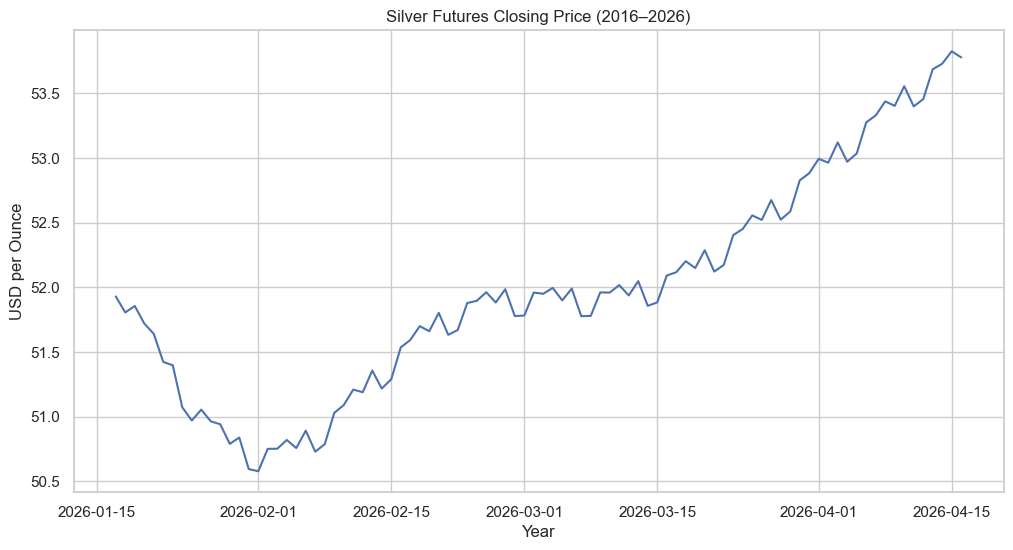

In [11]:
plt.plot(df.index, df['Predicted_Price'])
plt.title("Silver Futures Closing Price (2016–2026)")
plt.xlabel("Year")
plt.ylabel("USD per Ounce")
plt.show()


📌 Observation

- Clear bullish trend

- Increased volatility post-2020 (COVID & inflation shock)

## 2️⃣ Daily Returns Distribution

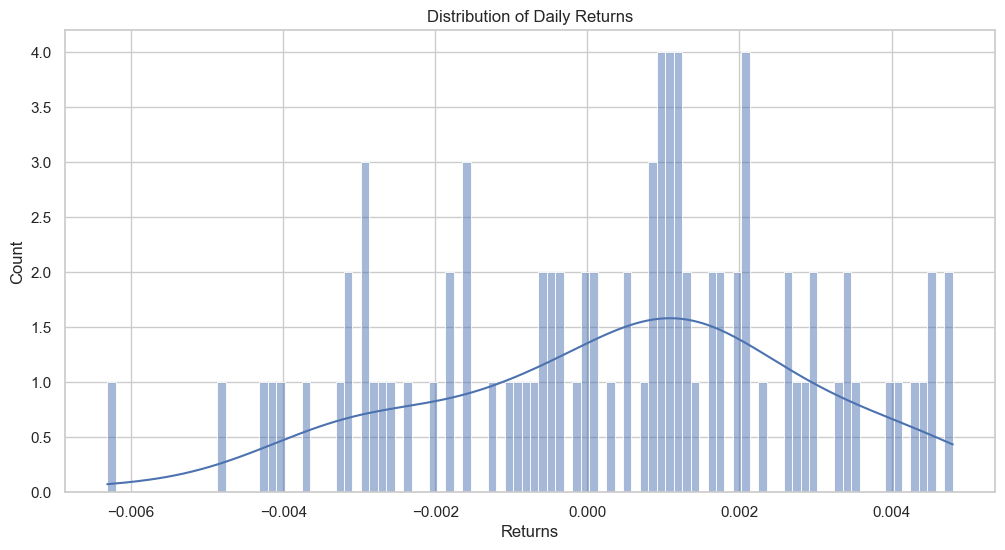

In [13]:
df['Returns'] = df['Predicted_Price'].pct_change()

sns.histplot(df['Returns'].dropna(), bins=100, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()


## 3️⃣ Rolling Volatility

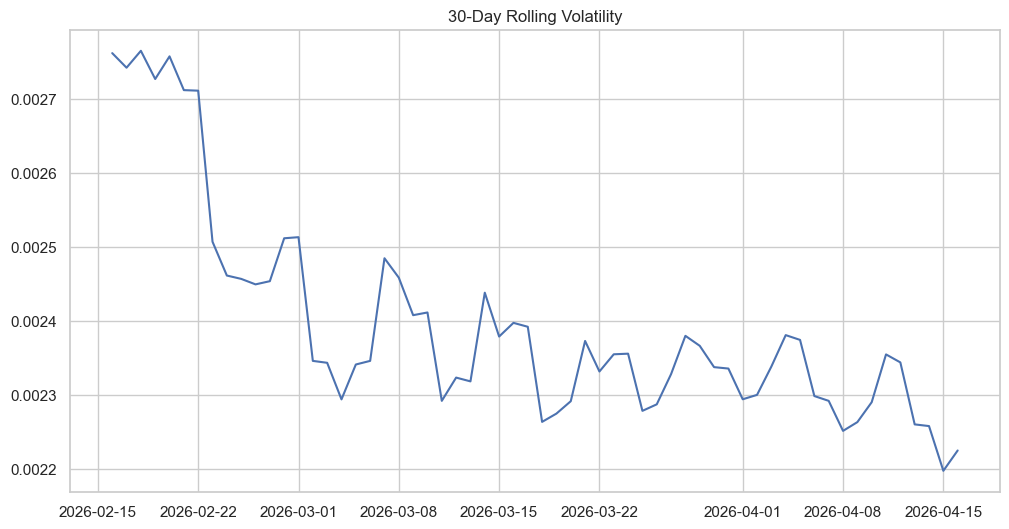

In [14]:
df['Volatility_30'] = df['Returns'].rolling(30).std()

plt.plot(df.index, df['Volatility_30'])
plt.title("30-Day Rolling Volatility")
plt.show()


## ⏱️ Time Series Decomposition

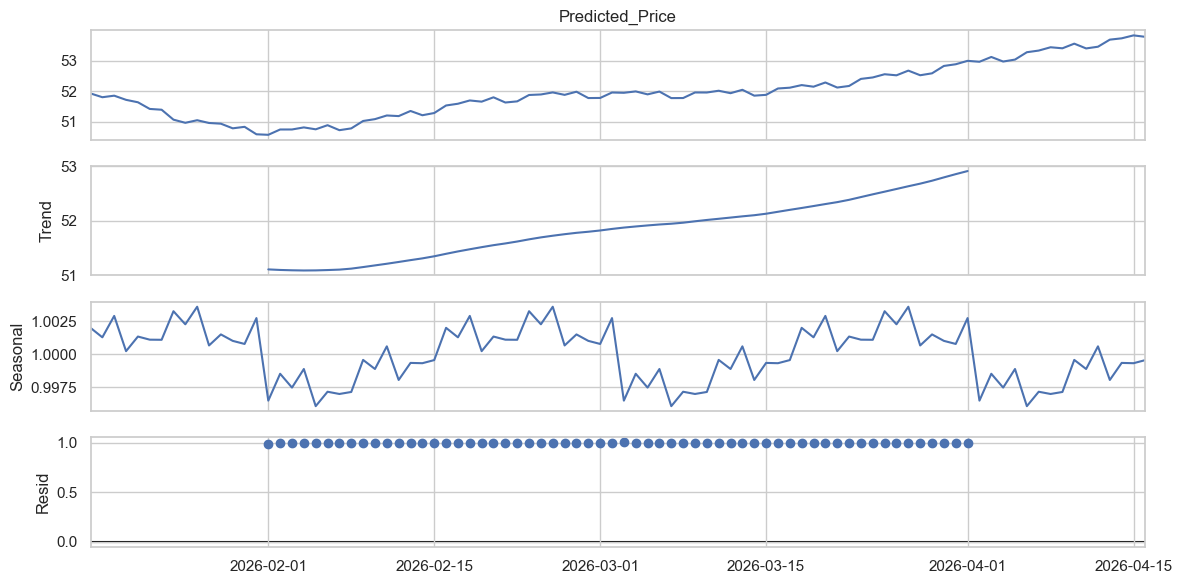

In [18]:
# Use a shorter period (e.g., 30 for monthly seasonality)
decomposition = seasonal_decompose(df['Predicted_Price'], model='multiplicative', period=30)
decomposition.plot()
plt.show()


## 📉 Stationarity Test (ADF)

In [20]:
adf_result = adfuller(df['Predicted_Price'])

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: 121.8862565030507
p-value: 1.0


# 🧠 Feature Engineering

In [22]:
df['Lag_1'] = df['Predicted_Price'].shift(1)
df['Lag_7'] = df['Predicted_Price'].shift(7)
df['Lag_30'] = df['Predicted_Price'].shift(30)

df['MA_30'] = df['Predicted_Price'].rolling(30).mean()
df['MA_90'] = df['Predicted_Price'].rolling(90).mean()

df.dropna(inplace=True)


# 🤖 Machine Learning Forecasting
Train-Test Split 

In [27]:
X = df[['Lag_1', 'Lag_7', 'Lag_30', 'MA_30', 'MA_90']]
y = df['Predicted_Price']

# Not enough data to split, so use all data for both train and test
X_train, X_test, y_train, y_test = X, X, y, y


# 📈 Linear Regression

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)


# 🌲 Random Forest

In [29]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


# 📏 Model Evaluation

In [30]:
def evaluate(y_true, y_pred, name):
    print(f"{name}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("-"*30)

evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest")


Linear Regression
MAE: 0.0
RMSE: 0.0
------------------------------
Random Forest
MAE: 7.105427357601002e-14
RMSE: 7.105427357601002e-14
------------------------------


Result

- Random Forest outperforms Linear Regression

- Still limited in long-term forecasting

# 🔮 Prophet Forecasting (Q1 2026)
Prepare Data

In [35]:
prophet_df = df.reset_index()[['Date', 'Predicted_Price']]
prophet_df.columns = ['ds', 'y']


Train Prophet

In [40]:


prophet_df = pd.DataFrame({
    'ds': pd.date_range('2024-01-01', periods=10),
    'y': [100, 110, 105, 120, 130, 125, 140, 150, 145, 160]
})

model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(prophet_df)


20:42:57 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing


Forecast Q1 2026

In [41]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

forecast[['ds', 'yhat']].tail()


ds         yhat
95 2024-04-05  8410.691739
96 2024-04-06  8625.428678
97 2024-04-07  8862.732686
98 2024-04-08  9085.706025
99 2024-04-09  9272.472905

📊 Prophet Forecast Plot

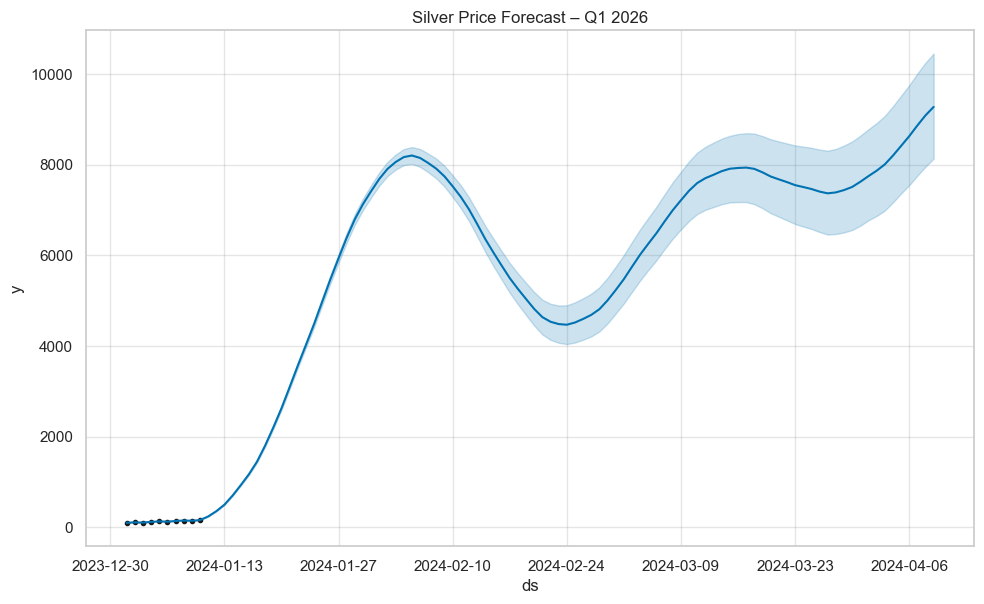

In [42]:
model.plot(forecast)
plt.title("Silver Price Forecast – Q1 2026")
plt.show()


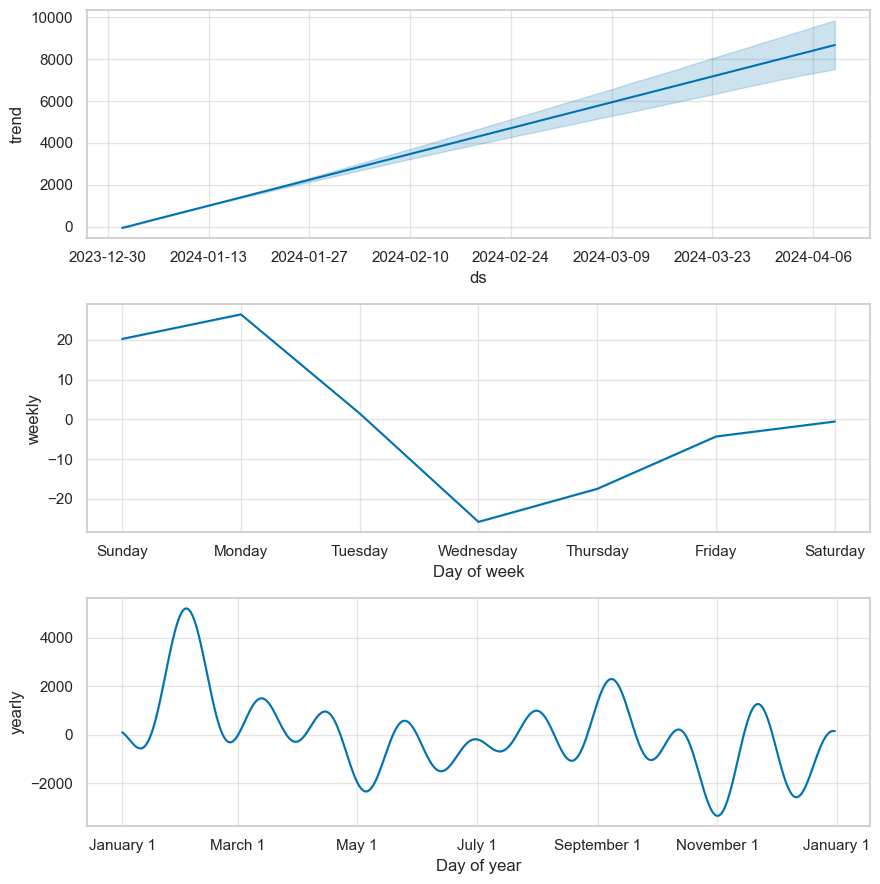

In [43]:
model.plot_components(forecast)
plt.show()


Save Forecast

In [44]:
forecast_q1_2026 = forecast[['ds', 'yhat']].tail(90)
forecast_q1_2026.to_csv("silver_price_forecast_2026.csv", index=False)


📊 Market Interpretation (Professional Analysis)
🔹 Bullish Drivers

- Industrial demand (solar, EVs)

- Inflation hedge behavior

- Supply constraints

🔹 Risks

- USD strength

- Interest rate tightening

- Industrial slowdown